In [72]:
# imports
import pandas as pd
import numpy as np

In [73]:
df = pd.read_csv("Serie_casos-AM.csv")
df.head()

,BR Cod Mun Infecção,NM MUN (MUNINF.csv),Year of BR Data de Notificação,Number of Records
0,130002,Alvarães,2018,1293
1,130002,Alvarães,2017,1535
2,130002,Alvarães,2016,522
3,130002,Alvarães,2015,1935
4,130002,Alvarães,2014,1589


In [74]:
# Renomeando as colunas
df.rename(columns={'BR Cod Mun Infecção':'Codigo', 'NM MUN (MUNINF.csv)':'Municipio',
                 'Year of BR Data de Notificação':'Ano', 'Number of Records':'Casos'},
         inplace=True)

In [75]:
df['Municipio'].value_counts()

Alvarães              12
Itapiranga            12
Jutaí                 12
Lábrea                12
Manacapuru            12
                      ..
Amaturá               11
Boa Vista do Ramos     9
Nhamundá               9
Barreirinha            8
Urucurituba            8
Name: Municipio, Length: 62, dtype: int64

In [76]:
# Agrupando por município para calcular a média e mediana de cada cidade durante o período
grouped = df.groupby('Municipio')

newCSV = grouped['Casos'].agg([np.mean, np.median, np.sum])
newCSV

,mean,median,sum
Municipio,,,
Alvarães,1996.333333,1762.0,23956
Amaturá,72.818182,25.0,801
Anamã,39.333333,7.5,472
Anori,32.818182,3.0,361
Apuí,288.750000,189.5,3465
...,...,...,...
Tefé,3458.833333,2367.0,41506
Tonantins,58.416667,21.5,701
Uarini,1171.333333,1287.0,14056


In [77]:
# Escrevendo um novo arquivo csv
newCSV.to_csv("Serie_casos-AM-mod.csv")

# Cluterização

In [78]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


In [79]:
data = pd.read_csv("Serie_casos-AM-mod.csv")

X = data.values[:,1:]
X = np.nan_to_num(X)

<function matplotlib.pyplot.show(close=None, block=None)>

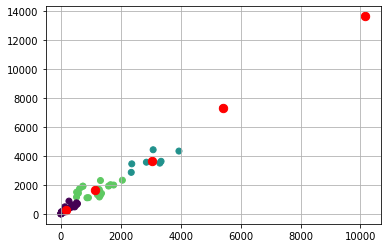

In [80]:
k_means = KMeans(init = "k-means++", n_clusters = 5, n_init = 10, max_iter=300)
pred_y = k_means.fit_predict(X)
plt.scatter(X[:,1], X[:,0], c = pred_y)
plt.grid()
plt.scatter(k_means.cluster_centers_[:,1], k_means.cluster_centers_[:,0], s=70, c='red')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

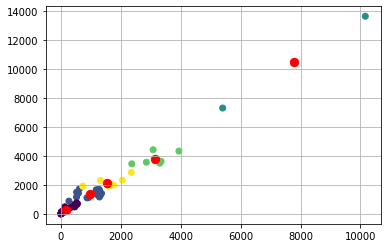

In [81]:
k_means = KMeans(init = "random", n_clusters = 5, n_init = 10, max_iter=100)
pred_y = k_means.fit_predict(X)
plt.scatter(X[:,1], X[:,0], c = pred_y)
plt.grid()
plt.scatter(k_means.cluster_centers_[:,1], k_means.cluster_centers_[:,0], s=70, c='red')
plt.show

# Choropleth map

In [82]:
import json

amazon_cities = json.load(open("AM.json", "r"))
amazon_cities['features'][0]['properties']

{'GEOCODIGO': '1300201', 'NOME': 'Atalaia do Norte', 'UF': 'AM'}

In [83]:
cities_id_map = {}

for feature in amazon_cities['features']:
    feature['id'] = feature['properties']['GEOCODIGO']
    cities_id_map[feature['properties']['NOME']] = feature['id']

In [84]:
data['id'] = data['Municipio'].apply(lambda x: cities_id_map[x])

In [85]:
data.head()

,Municipio,mean,median,sum,id
0,Alvarães,1996.333333,1762.0,23956,1300029
1,Amaturá,72.818182,25.0,801,1300060
2,Anamã,39.333333,7.5,472,1300086
3,Anori,32.818182,3.0,361,1300102
4,Apuí,288.750000,189.5,3465,1300144


In [86]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'firefox'

In [143]:
data['meanScale'] = np.log10(data['mean'])

data.loc[(data['meanScale'] > 4), 'cluster'] = 5
data.loc[np.logical_and((data['meanScale'] < 4), (data['meanScale'] > 3)), 'cluster'] = 4
data.loc[np.logical_and((data['meanScale'] <= 3), (data['meanScale'] > 2)), 'cluster'] = 3
data.loc[np.logical_and((data['meanScale'] <= 2), (data['meanScale'] > 1)), 'cluster'] = 2
data.loc[(data['meanScale'] <= 1), 'cluster'] = 1

data.head()



,Municipio,mean,median,sum,id,meanScale,cluster
0,Alvarães,1996.333333,1762.0,23956.0,1300029,3.300233,4.0
1,Amaturá,72.818182,25.0,801.0,1300060,1.862240,2.0
2,Anamã,39.333333,7.5,472.0,1300086,1.594761,2.0
3,Anori,32.818182,3.0,361.0,1300102,1.516115,2.0
4,Apuí,288.750000,189.5,3465.0,1300144,2.460522,3.0


In [144]:
fig = px.choropleth(data,
                    locations='id', 
                    geojson=amazon_cities, 
                    color='cluster', 
                    hover_name='Municipio',
                    hover_data=['mean'])
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

In [145]:
fig_mapbox = px.choropleth_mapbox(data,
                    locations='id', 
                    geojson=amazon_cities, 
                    color='cluster', 
                    hover_name='Municipio',
                    hover_data=['mean'],
                    mapbox_style="carto-positron",
                    center={'lat': 24, 'lon':78},
                    zoom=3, 
                    opacity=0.5,
                    )
fig_mapbox.show()